# Machine Learning used to build a Diversified Portfolio: K-Means Clustering

**Hugh Donnelly, CFA**<br> 
*AlphaWave Data*

**September 2021**

## Introduction
<p>
    In this article, we will explore K-Means Clustering:<br>
    <ul>
        <li><a href="#definition"> What is K-Means Clustering? </li>
        <li><a href="#algorithm">Algorithm</a></li>
        <li><a href="#application">K-Means Clustering Application: Building a diversified portfolio</a></li>
    </ul>
</p>

Jupyter Notebooks are available on [Google Colab](https://colab.research.google.com/drive/1m5zWDrHGxEEnJoxNKQn4VXCuRK54jmj1?usp=sharing) and [Github](https://github.com/AlphaWaveData/Jupyter-Notebooks/blob/master/AlphaWave%20Data%20Machine%20Learning%20used%20to%20build%20a%20Diversified%20Portfolio%20with%20K-Means%20Clustering%20example.ipynb).

For this project, we use several Python-based scientific computing technologies listed below.

In [1]:
import time
import kneed
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import ipywidgets as widgets 
from scipy.stats import mstats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from requests.adapters import HTTPAdapter
from requests.exceptions import ConnectionError
from requests.packages.urllib3.util.retry import Retry

/Users/Hugh/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<a name="definition"></a>
<h2><span style="color:black">What is K-Means Clustering?  </span></h2>
<p>
K-Means Clustering is a form of unsupervised <a href="https://hdonnelly6.medium.com/list/machine-learning-for-investing-7f2690bb1826">machine learning</a> (ML). It is considered to be one of the simplest and most popular unsupervised machine learning techniques.
Unsupervised algorithms use vectors on data points. These data points are not labeled or classified. Our goal is to discover hidden patterns and group the data points in a sensible way based on similarity of features. Each group of data points is a cluster and each cluster will have a center.

<img src="img/k_means.png">

<a href="https://www.analyticsvidhya.com/blog/2021/04/k-means-clustering-simplified-in-python/">Source : Analytics Vidhya </a>

### Examples

Let's imagine you have two dimensional data that is not labeled as shown below and you are asked to form clusters.

#### Row data

<img src="img/k_means_row_data.PNG">

Below is an example of good clustering.

#### Good Clustering

<img src="img/k_means_good_clustering.PNG" >

However, clustering can go wrong as seen below.

#### Naive Clustering

<img src="img/k_means_bad_clustering.PNG" >

Source: Oreilly.com : Clustering and Unsupervised Learning

<a name="algorithm"></a>
<h2><span style="color:black">Algorithm </span></h2>

* Pre-process the data (Clean it, Scale it, Standardize it)
* Select K
* Pick K Centers 
* Repeat until there is no change of the centroid positions: <BR>
   1) Compute the distance between data point (vector x) and all centroids. (Generally, we use the euclidean distance) <img src="img/k_means_euclidean.png" >
   2) Assign each data point to the closest cluster (centroid) <img src="img/k_means_argmin.png" >
   3) Compute the centroids for the clusters by taking the average of all data points that belong to each cluster.
 

 <img src="img/k_means_algorithm.PNG"  width="40%" >

Training examples are shown as dots, and cluster centroids are shown as crosses.
    <ul>
        (a) Original dataset.<br>
        (b) Random initial cluster centroids.<br>
        (c-f) Illustration of running two iterations of k-means.<br>
    </ul>
In each iteration, we assign each training example to the closest cluster centroid (shown by "painting" the training examples the same color as the cluster centroid to which it is assigned). Then we move each cluster centroid to the mean of the points assigned to it.

<a href="https://stanford.edu/~cpiech/cs221/handouts/kmeans.html">Source : Stanford Edu ( K-Means) </a>


<a name="application"></a>
<h2><span style="color:black">K-Means Clustering Application: Building a diversified portfolio </span></h2>

We are going to use K-Means Clustering to build a diversified portfolio. Two ratios will be used in order to cluster the data: <BR>
<ul>
    <li> <code>Revenue per share:</code> Amount of sales or revenues generated per average total shares outstanding. (Sales Revenue/Average Total Shares)</li>
    <li><code>Return on Assets:</code> Indicator of how profitable company is relative to its assets (Total Income /Total Assets)</li>

</ul>
The idea is to create clusters with similar characteristics for the components of the S&P 500 using these two factors at the end of the 2021 Q1. From each cluster, we will take the stocks with highest risk adjusted momentum to build our portfolio. <br><br>
   After building this portfolio, we will run it for 2021 Q2 and compare it to the return of the S&P 500.<br><br>
    
Please note that this analysis is done using only two factors which leads to a two dimensional problem. We are using a two dimensional problem to demonstrate the concept and understand the problem. Multiple factors can be used as well. If you want to use multiple factors, you may want to use <a href="https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html">Principal Component Analysis</a> to lower the number of dimensions. <br><br>
   
We will proceed with the following steps: <br><b>K-Means Clustering : </b><br>

    1. Get the data: Revenue per share and Return on Assets for the end of 2021 Q1 for members of the S&P 500.
    2. Analyze the data, clean it and visualize it.
    3. Choose K.
    4. Analyze the clustering results.
<b>Portfolio Construction : </b><br>
    
    1. From each cluster, choose the stocks with the highest risk adjusted momentum. 
    2. Run the portfolio return for 2021-Q2.

----
Let's apply the steps defined above:
## K-Means Clustering 
### <I>1. Get the data: Revenue per share and Return on Assets for the end of 2021 Q1 for members of the S&P 500</I>

In [2]:
# Scrape the S&P 500 tickers from Wikipedia

def get_tickers():
    wiki_page = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies').text
    sp_data = pd.read_html(wiki_page)
    ticker_df = sp_data[0]
    ticker_options = ticker_df['Symbol']
    return ticker_options

In [34]:
# Run the ticker scrape function
# Let's convert the get_tickers() output to a list and 
# replace tickers that have '.' with '-' so we can use AlphaWave Data APIs

stock_tickers = get_tickers()
stock_tickers = stock_tickers.to_list()
for ticker in range(len(stock_tickers)):
    stock_tickers[ticker] = stock_tickers[ticker].upper().replace(".", "-")

print (len(stock_tickers))
# stock_tickers

505


We can use the [Key Statistics](https://rapidapi.com/alphawave/api/stock-analysis?endpoint=apiendpoint_dff4b882-4be4-4169-a700-04275c92bdce) endpoint from the [AlphaWave Data Stock Analysis API](https://rapidapi.com/alphawave/api/stock-analysis/endpoints) to pull in the required stock information.

To call this API with Python, you can choose one of the supported Python code snippets provided in the API console. The following is an example of how to invoke the API with Python Requests. You will need to insert your own <b>x-rapidapi-host</b> and <b>x-rapidapi-key</b> information in the code block below.

In [4]:
# Fetch AlphaWave Data's fundamental stock information
key_stats_url = "https://stock-analysis.p.rapidapi.com/api/v1/resources/key-stats"

headers = {
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

retry_strategy = Retry(total=3, backoff_factor=10, status_forcelist=[429, 500, 502, 503, 504], method_whitelist=["HEAD", "GET", "PUT", "DELETE", "OPTIONS", "TRACE"])
rapid_api_adapter = HTTPAdapter(max_retries=retry_strategy)
http = requests.Session()
http.mount("https://", rapid_api_adapter)

alphawave_data = []

for ticker in tqdm(stock_tickers, position=0, leave=True, desc = "Retrieving AlphaWave Data Stock Info"):
    
    querystring = {"ticker":ticker}
    time.sleep(3)
    
    try:
        
        # Get Key Stats
        key_stats_response = http.get(key_stats_url, headers=key_stats_headers, params=querystring, timeout=(5, 5))
        key_stats_response.raise_for_status()
        key_stats_df = pd.DataFrame.from_dict(key_stats_response.json())
        key_stats_df = key_stats_df.transpose()

        roa = key_stats_df.loc[r'Return on assets (ttm)'][0]
        rev_per_share = key_stats_df.loc[r'Revenue per share (ttm)'][0]

        # Create Dataframe
        df = pd.DataFrame({'Return on Assets': roa,
                           'Rev per share': rev_per_share},
                          index=[ticker])

        alphawave_data.append(df)

    except requests.exceptions.RequestException as err:
        print ("OOps: Something Else",err)
    except requests.exceptions.HTTPError as errh:
        print ("Http Error:",errh)
    except requests.exceptions.ConnectionError as errc:
        print ("Error Connecting:",errc)
    except requests.exceptions.Timeout as errt:
        print ("Timeout Error:",errt)
        
    except:
        pass

data = pd.concat(alphawave_data, ignore_index=False)
data

Retrieving AlphaWave Data Stock Info: 100%|██████████| 505/505 [37:55<00:00,  4.51s/it]


,Return on Assets,Rev per share
MMM,10.93%,59.94
ABT,7.19%,22.65
ABBV,7.94%,30.36
ABMD,12.24%,20.68
ACN,11.67%,75.47
...,...,...
YUM,20.33%,19.47
ZBRA,11.41%,96.69
ZBH,2.39%,34.18
ZION,1.39%,19.58


In [7]:
# Remove any % characters, change string values to numeric values
data[["Return on Assets"]] = data[["Return on Assets"]].apply(lambda x: x.str.replace('[%]','', regex=True))
data[["Return on Assets", 
      "Rev per share"]] = data[["Return on Assets", 
                                   "Rev per share"]].apply(pd.to_numeric)
data[["Return on Assets"]] = data[["Return on Assets"]].apply(lambda x: x/100)
data.index.name = 'ID'

data

,Return on Assets,Rev per share
ID,,
MMM,0.1093,59.94
ABT,0.0719,22.65
ABBV,0.0794,30.36
ABMD,0.1224,20.68
ACN,0.1167,75.47
...,...,...
YUM,0.2033,19.47
ZBRA,0.1141,96.69
ZBH,0.0239,34.18


### <I>2. Analyze the data, clean it and visualize it.</I>

In [8]:
data.shape

(505, 2)

In [9]:
data.describe()

,Return on Assets,Rev per share
count,502.000000,505.000000
mean,0.062860,400.912376
std,0.055882,7499.921615
min,-0.129500,0.070000
25%,0.026150,18.890000
50%,0.052000,32.020000
75%,0.087475,64.800000
max,0.296500,168571.660000


In [10]:
# Make a copy of the original data before starting our data preprocessing
original_data=data.copy()

In [11]:
#Check Na Values
data[data['Return on Assets'].isna() | data['Rev per share'].isna()]

,Return on Assets,Rev per share
ID,,
GL,NaN,47.56
OGN,NaN,31.13
WRB,NaN,47.48


In [12]:
# Dropna value 
data=data.dropna()
data

,Return on Assets,Rev per share
ID,,
MMM,0.1093,59.94
ABT,0.0719,22.65
ABBV,0.0794,30.36
ABMD,0.1224,20.68
ACN,0.1167,75.47
...,...,...
YUM,0.2033,19.47
ZBRA,0.1141,96.69
ZBH,0.0239,34.18


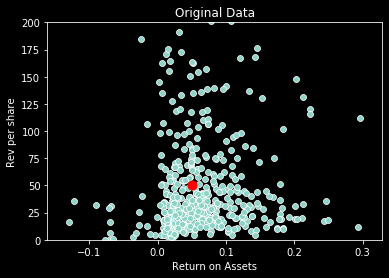

In [13]:
# Visualize scatterplot
plt.style.use("dark_background")
g = sns.scatterplot(x='Return on Assets', y='Rev per share', data=data)
plt.ylim([0,200])
plt.title("Original Data")

# Some random point we want to classify
plt.scatter(0.05, 50, marker='o', s=80, color='red')

In [14]:
# Both Revenue per share and Return on Assets are ratios. They are already scaled to the company size.
# We can use Winsorization to transforms data by limiting extreme values, typically by setting all outliers to a specified percentile of data
X =np.asarray([np.asarray(data['Return on Assets']),np.asarray(data['Rev per share'])])
X = mstats.winsorize(X, limits = [0.05, 0.05])
data=pd.DataFrame(X, index=['Return on Assets','Rev per share'], columns=data.index).T
data.head()

,Return on Assets,Rev per share
ID,,
MMM,0.1093,59.94
ABT,0.0719,22.65
ABBV,0.0794,30.36
ABMD,0.1224,20.68
ACN,0.1167,75.47


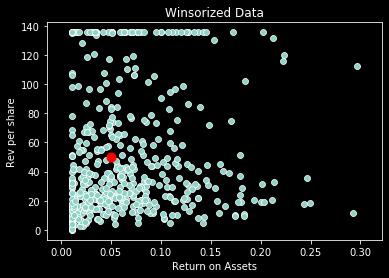

In [15]:
# Visualize scatterplot
plt.style.use("dark_background")
g = sns.scatterplot(x='Return on Assets', y='Rev per share', data=data)
plt.title("Winsorized Data")

# Some random point we want to classify
plt.scatter(0.05, 50, marker='o', s=80, color='red')
plt.show()

### <I>3. Choose K</I>

The two most common methods to choose K ( the appropriate number of clusters) are :
    <ul>
        <li>The silhouette Coefficient</li>
        <li>The Elbow Method </li>
    </ul>

The silhouette coefficient is a value that ranges between -1 and 1. It quantifies how well a data point fits into its assigned cluster based on two factors:
1. How close the data point is to other points in the cluster
2. How far away the data point is from points in other clusters

Larger numbers for Silhouette coefficient indicate that samples are closer to their clusters than they are to other clusters.

The elbow method is used by running several k-means, increment k with each iteration, and record the SSE ( Sum Of Squared Error) <br><br>
$$SSE= Sum  \; Of  \; Euclidean  \; Squared  \; Distances  \; of  \; each  \; point \; to \; its  \; closest \; centroid $$<br>
After that , we plot SSE as a function of the number of clusters. SSE continues to decrease as you increase k. As more centroids are added, the distance from each point to its closest centroid will decrease.
There’s a sweet spot where the SSE curve starts to bend known as the elbow point. The x-value of this point is thought to be a reasonable trade-off between error and number of clusters. <br>

<a href="https://realpython.com/k-means-clustering-python/#choosing-the-appropriate-number-of-clusters"> (Source)</a>

In this example, we will use the Elbow Method to determine K:

In [16]:
distorsions = []
clusters_iterations=range(2, 20)
for k in clusters_iterations:
    k_means = KMeans(n_clusters=k)
    k_means.fit(data)
    distorsions.append(k_means.inertia_)

In [17]:
elbow_curve_data=pd.DataFrame(zip(clusters_iterations,distorsions),columns=['Cluster','SSE']).set_index('Cluster')
elbow_curve_data.head()

,SSE
Cluster,
2,168519.799163
3,67633.824231
4,37234.562646
5,23070.887920
6,15687.451817


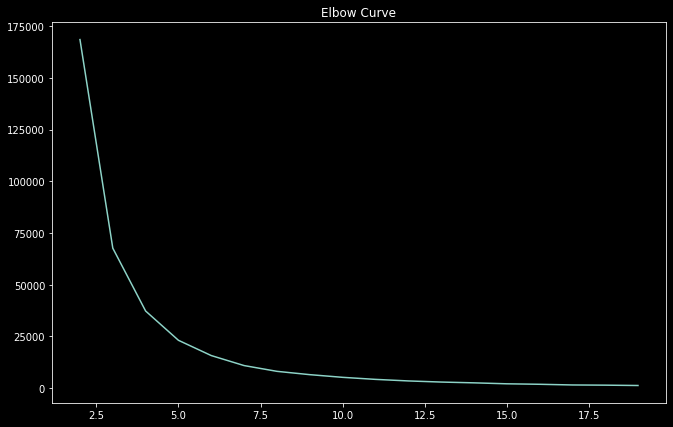

In [18]:
# Visualize plot
plt.figure(figsize=(11,7))
plt.style.use("dark_background")
plt.plot(elbow_curve_data['SSE'])
plt.title("Elbow Curve")

plt.show()

In [19]:
# get elbow programmatically
from kneed import KneeLocator 
kl = KneeLocator(
clusters_iterations, distorsions, curve="convex", direction="decreasing")
elbow=kl.elbow

print('Elbow = {}'.format(elbow))

Elbow = 5


### <I>4. Analyze the clustering results</I>

In [20]:
# We apply KMeans for the Elbow's value  ( in this case = 5)
kmeans = KMeans(n_clusters=elbow)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)
df_kmeans = data.copy()
df_kmeans['cluster']=y_kmeans.astype(str)

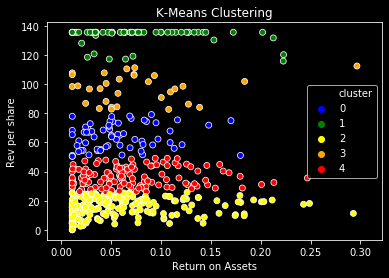

In [21]:
# Visualize the results
plt.style.use("dark_background")
g = sns.scatterplot(x='Return on Assets', y='Rev per share', hue=df_kmeans['cluster'].astype(int), 
                    palette=['blue','green','yellow','orange','red'], data=df_kmeans)
plt.title("K-Means Clustering")

# Some random point we want to classify
plt.show()

In [22]:
# see the centers 
clusters_centers_df=pd.DataFrame(kmeans.cluster_centers_,columns=['Return on Assets','Rev per share'])
clusters_centers_df

,Return on Assets,Rev per share
0,0.057726,63.871077
1,0.076280,133.355625
2,0.060268,15.883474
3,0.076032,97.086129
4,0.070734,36.405891


In [23]:
# See the clustering by Company 
clustering_result=pd.DataFrame(zip(y_kmeans,data.index),columns=['Cluster','Company'])
clustering_result.set_index('Cluster').head()

,Company
Cluster,
0,MMM
2,ABT
4,ABBV
2,ABMD
0,ACN


In [24]:
for cluster_num in list(clustering_result.set_index('Cluster').index.unique()):
    print (clustering_result.set_index('Cluster').loc[cluster_num].head())

        Company
Cluster        
0           MMM
0           ACN
0           AIG
0           AON
0          APTV
        Company
Cluster        
2           ABT
2          ABMD
2          ATVI
2           AMD
2           AES
        Company
Cluster        
4          ABBV
4          ADBE
4           AFL
4           APD
4           ALK
        Company
Cluster        
1           AAP
1           ALL
1         GOOGL
1          GOOG
1          AMZN
        Company
Cluster        
3           AMP
3           AVY
3           BIO
3            BA
3           CAT


In [25]:
# Enrich Centers Df with the number of elements by Cluster
clusters_centers_df['Count']=clustering_result['Cluster'].value_counts().to_frame().rename(columns={'Cluster':'Count'})['Count']
clusters_centers_df.head()

,Return on Assets,Rev per share,Count
0,0.057726,63.871077,65
1,0.076280,133.355625,64
2,0.060268,15.883474,213
3,0.076032,97.086129,31
4,0.070734,36.405891,129


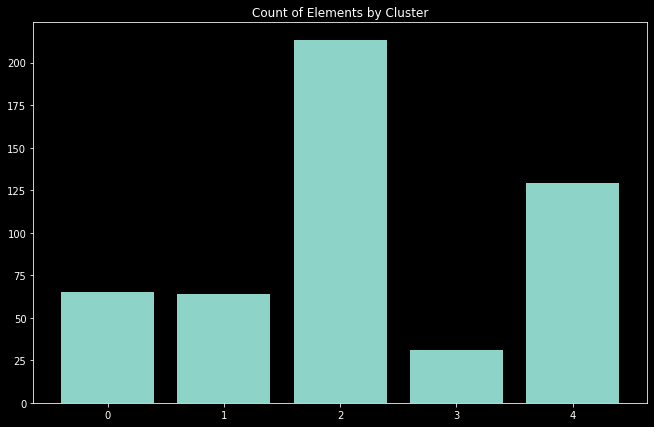

In [26]:
# Visualize Count of Elements by Cluster 
plt.figure(figsize=(11,7))
plt.style.use("dark_background")
plt.bar(clusters_centers_df.index.values,clusters_centers_df['Count'])
plt.title("Count of Elements by Cluster")

plt.show()

## Portfolio Construction
### <I>1. From each cluster, choose the stocks with the highest Risk Adjusted Momentum </I>

We can use the [2 Year Historical Daily Prices](https://rapidapi.com/alphawave/api/stock-prices2?endpoint=apiendpoint_33fa1878-1727-4775-beeb-f6b0da5314fd) endpoint from the [AlphaWave Data Stock Prices API](https://rapidapi.com/alphawave/api/stock-prices2/endpoints) to pull in the two year historical prices.

To call this API with Python, you can choose one of the supported Python code snippets provided in the API console. The following is an example of how to invoke the API with Python Requests. You will need to insert your own <b>x-rapidapi-host</b> and <b>x-rapidapi-key</b> information in the code block below.

In [27]:
#fetch 2 year daily return data

url = "https://stock-prices2.p.rapidapi.com/api/v1/resources/stock-prices/2y"

headers = {
    'x-rapidapi-host': "YOUR_X-RAPIDAPI-HOST_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS",
    'x-rapidapi-key': "YOUR_X-RAPIDAPI-KEY_WILL_COPY_DIRECTLY_FROM_RAPIDAPI_PYTHON_CODE_SNIPPETS"
    }

stock_frames = []

# for ticker in stock_tickers:
for ticker in tqdm(stock_tickers, position=0, leave=True, desc = "Retrieving AlphaWave Data Stock Info"):
    
    querystring = {"ticker":ticker}
    stock_daily_price_response = requests.request("GET", url, headers=headers, params=querystring)

    # Create Stock Prices DataFrame
    stock_daily_price_df = pd.DataFrame.from_dict(stock_daily_price_response.json())
    stock_daily_price_df = stock_daily_price_df.transpose()
    stock_daily_price_df = stock_daily_price_df.rename(columns={'Close':ticker})
    stock_daily_price_df = stock_daily_price_df[{ticker}]
    stock_frames.append(stock_daily_price_df)

combined_stock_price_df = pd.concat(stock_frames, axis=1, sort=True)
combined_stock_price_df = combined_stock_price_df.dropna(how='all')
combined_stock_price_df = combined_stock_price_df.fillna("")
combined_stock_price_df

Retrieving AlphaWave Data Stock Info: 100%|██████████| 505/505 [10:35<00:00,  1.26s/it]


,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,WLTW,WYNN,XEL,XLNX,XYL,YUM,ZBRA,ZBH,ZION,ZTS
2019-09-09,154.981232,81.63871,59.288097,186.809998,189.160187,54.565197,279.299988,30.5,144.989563,14.154182,...,190.402863,112.754280,60.126400,103.516769,75.715034,113.642380,196.809998,135.137802,39.775383,125.237442
2019-09-10,157.708389,80.65966,60.603638,191.820007,184.14064,55.395687,276.140015,30.23,152.139206,14.295442,...,184.716019,114.957245,59.746990,104.703911,76.545448,111.192238,192.639999,136.557404,40.986385,121.648193
2019-09-11,156.979919,81.929497,61.76807,191.070007,185.800858,54.288364,277.779999,29.76,156.230331,14.643881,...,186.712265,112.429741,59.993603,103.065460,77.463799,109.774239,197.419998,138.302322,41.446384,119.344376
2019-09-12,159.314804,82.598351,62.959167,188.020004,189.830093,54.822258,278.019989,30.209999,152.630905,14.756888,...,189.584900,115.144096,60.208393,103.045822,76.271904,109.262985,197.279999,140.589462,41.896992,120.323257
2019-09-13,160.118011,81.687164,62.674721,186.410004,188.956284,55.316593,278.350006,30.690001,154.401108,14.869897,...,189.594635,115.517815,59.769260,103.251862,76.858070,107.420563,205.160004,136.823578,42.028416,119.660774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,193.440002,127.400002,112.269997,363.269989,337.899994,82.300003,665.890015,109.989998,201.880005,24.120001,...,223.699997,100.980003,69.750000,154.470001,136.550003,131.550003,582.780029,150.869995,57.169998,206.440002
2021-09-02,194.889999,128.490005,112.019997,369.829987,341.0,81.309998,664.640015,109.199997,200.809998,24.530001,...,230.059998,102.000000,70.320000,154.139999,138.029999,131.270004,588.250000,149.089996,57.150002,209.220001
2021-09-03,194.389999,128.940002,111.620003,372.690002,343.329987,81.18,666.590027,109.919998,199.440002,24.639999,...,228.520004,100.300003,69.800003,155.960007,137.250000,130.919998,590.599976,146.740005,57.119999,209.690002
2021-09-07,,,,,,,,,,,...,227.100006,105.930000,67.900002,154.750000,135.649994,128.830002,581.140015,146.619995,57.500000,207.809998


In [30]:
# Build of Portfolio of 50 stocks
number_of_stocks=50

# From each Cluster, we will pick the stocks with the highest risk adjusted momentum. The number of stocks from each cluster is proportional to its size
# Let's start by calculate the number of stocks to pick from each cluster
number_of_stocks_by_cluster=pd.DataFrame(round(number_of_stocks*clustering_result.groupby(by='Cluster').count()['Company']/clustering_result.count()['Company'],0))
number_of_stocks_by_cluster

,Company
Cluster,
0,6.0
1,6.0
2,21.0
3,3.0
4,13.0


In [31]:
# From each Cluster, pick the stocks with the highest risk adjusted momentum.
as_of_date='2021-03-30'

portfolio_stocks=[]
for cluster_num in list(number_of_stocks_by_cluster.index):
    # for each cluster,get all the companies within this cluster
    list_stocks=list(clustering_result.set_index('Cluster').loc[cluster_num]['Company'])
    #get the number of stocks that we will pick for our portfolio     
    number_stocks=number_of_stocks_by_cluster.loc[cluster_num]['Company']
    if number_stocks>0:
        # Compute the risk adjusted momentum for the past year
        last_year_date=pd.to_datetime(as_of_date)+ pd.offsets.DateOffset(years=-1)
        last_month_date=pd.to_datetime(as_of_date)+ pd.tseries.offsets.BusinessDay(offset = timedelta(days = -30))
        stock_price_last_year_date = last_year_date.strftime('%Y-%m-%d')
        stock_price_last_month_date = last_month_date.strftime('%Y-%m-%d')
        
        risk_adjusted_mom_frames = []
        for ticker in list_stocks:

            try:
                momentum = (combined_stock_price_df.loc[stock_price_last_month_date,][ticker] - \
                            combined_stock_price_df.loc[stock_price_last_year_date,][ticker]) / \
                            combined_stock_price_df.loc[stock_price_last_year_date,][ticker]

                annualized_volatility = np.log(combined_stock_price_df.loc[stock_price_last_year_date:as_of_date,][ticker] / \
                                               combined_stock_price_df.loc[stock_price_last_year_date:as_of_date,][ticker].shift(1)).dropna().std()*252**.5

                risk_adjusted_momentum = momentum / annualized_volatility

                # Create Dataframe
                df = pd.DataFrame({'Risk Adj MoM': risk_adjusted_momentum},
                                  index=[ticker])

                risk_adjusted_mom_frames.append(df)

            except:
                pass

        risk_adjusted_mom_df = pd.concat(risk_adjusted_mom_frames, ignore_index=False)
        risk_adjusted_mom_df["Rank"] = risk_adjusted_mom_df["Risk Adj MoM"].rank(ascending=False)
        risk_adjusted_mom_df[["Risk Adj MoM", 
                              "Rank"]] = risk_adjusted_mom_df[["Risk Adj MoM", 
                                                               "Rank"]].apply(pd.to_numeric)
        filtered_risk_adjusted_mom_df = risk_adjusted_mom_df[risk_adjusted_mom_df['Rank'] <= number_stocks]
        portfolio_stocks=portfolio_stocks+list(filtered_risk_adjusted_mom_df.index)

portfolio_stocks

['PCAR',
 'PXD',
 'PPG',
 'RJF',
 'ROK',
 'TT',
 'POOL',
 'PVH',
 'TGT',
 'ULTA',
 'URI',
 'WHR',
 'MPWR',
 'NWSA',
 'NWS',
 'NVDA',
 'OKE',
 'PYPL',
 'PNR',
 'PTC',
 'RF',
 'RCL',
 'SLB',
 'SYF',
 'TPR',
 'TER',
 'TXN',
 'TRMB',
 'TWTR',
 'UAA',
 'UA',
 'WY',
 'WMB',
 'PWR',
 'SIVB',
 'ZBRA',
 'MS',
 'MOS',
 'NXPI',
 'PENN',
 'QRVO',
 'QCOM',
 'RHI',
 'SNPS',
 'TEL',
 'TSLA',
 'VIAC',
 'DIS',
 'WST']

### <I> 2. Compute Portfolio's Performance for 2021-Q2 </I>

In [32]:
# Since we chose our portfolio stocks by end the of 2021-Q1, we will run it for 2021-Q2 
end_date='2021-06-30'

# Compute the portfolio return. We will use equal weights for all the stocks
combined_stock_price_df = combined_stock_price_df.apply(pd.to_numeric)
s_p_500_daily_return = (combined_stock_price_df.loc[as_of_date:end_date,].pct_change().sum(axis=1).dropna()/len(combined_stock_price_df.columns)) + 1
cluster_portfolio_return=0
for stock in portfolio_stocks:
    daily_return = combined_stock_price_df.loc[as_of_date:end_date,][stock].pct_change().dropna() + 1
    cluster_portfolio_return=cluster_portfolio_return+(daily_return/len(portfolio_stocks))

# Create Dataframe
df = pd.DataFrame({'cluster_portfolio_return':cluster_portfolio_return,
                   'spx_index_return':s_p_500_daily_return},)

df.index.name = 'DATE'
return_ptf_index = df.dropna()
return_ptf_index = return_ptf_index.apply(pd.to_numeric)

return_ptf_index

,cluster_portfolio_return,spx_index_return
DATE,,
2021-03-31,1.009275,0.999547
2021-04-01,1.014843,1.010877
2021-04-05,1.013042,1.009535
2021-04-06,0.999495,1.001167
2021-04-07,0.994658,0.996562
...,...,...
2021-06-24,1.012652,1.006553
2021-06-25,1.003557,1.007312
2021-06-28,0.997640,0.995732


Portfolio Annual Excess Return : 40.91%
Portfolio Annual Volatility    : 17.11% 
Portfolio Sharpe Ratio         : 2.39


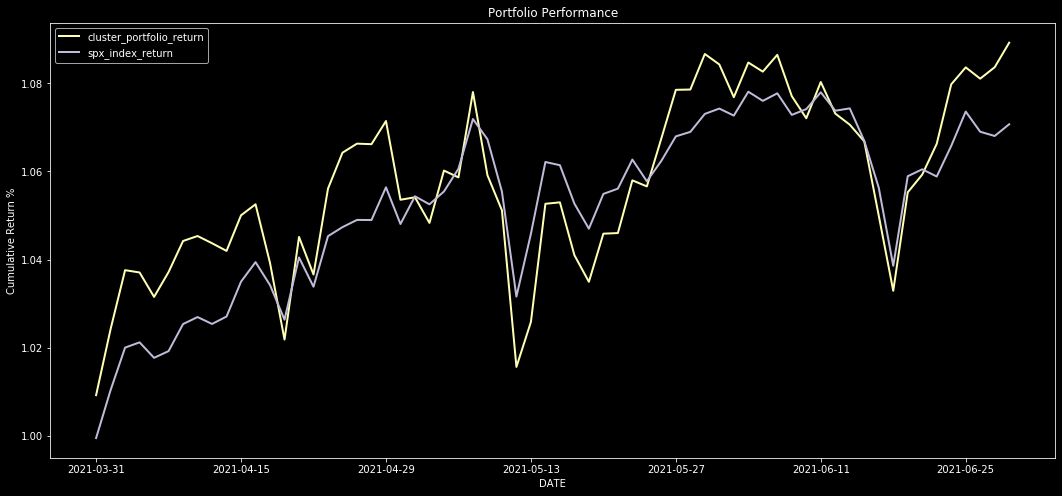

In [33]:
# Compute the annual volatility, sharpe ratio and annual excess return and plot the cumulative return
from math import sqrt

# compute the timeline for annualization
T = (pd.to_datetime(return_ptf_index['cluster_portfolio_return'].index[-1]) - pd.to_datetime(return_ptf_index['cluster_portfolio_return'].index[0])) / np.timedelta64(1, 'Y')

#portfolio Excess Return
portfolio_excess_return=round(100*(return_ptf_index['cluster_portfolio_return'].cumprod().iloc[-1]**(1/T) - 1),2)

#Portfolio Annual Volatility
portfolio_annual_volatility=round(100*return_ptf_index['cluster_portfolio_return'].std()*sqrt(252),2)

#Portfolio Sharpe Ratio
portfolio_sharpe_ratio=round((portfolio_excess_return)/portfolio_annual_volatility,2)

# Plot Results
print ("Portfolio Annual Excess Return : {}%".format(portfolio_excess_return))
print ("Portfolio Annual Volatility    : {}% ".format(portfolio_annual_volatility))
print ("Portfolio Sharpe Ratio         : {}".format(portfolio_sharpe_ratio)) 

plt.figure(figsize = (18,8))
ax = plt.gca()
plt.title("Portfolio Performance")
return_ptf_index['cluster_portfolio_return'].cumprod().plot(ax=ax,color=sns.color_palette()[1],linewidth=2)
return_ptf_index['spx_index_return'].cumprod().plot(ax=ax,color=sns.color_palette()[2],linewidth=2)
plt.ylabel("Cumulative Return %")
plt.legend()
plt.show()

You can repeat this analysis in order to build a portfolio that rebalances every end of Quarter.  Be sure the <code>as_of_date</code> and <code>end_date</code> variables are updated to reflect the most recent Quarter end and that these dates fit within the [2 Year Historical Daily Prices](https://rapidapi.com/alphawave/api/stock-prices2?endpoint=apiendpoint_33fa1878-1727-4775-beeb-f6b0da5314fd) endpoint from the [AlphaWave Data Stock Prices API](https://rapidapi.com/alphawave/api/stock-prices2/endpoints).

## References and Additional Resources
<ul>
  <li><a href ="https://hdonnelly6.medium.com/list/machine-learning-for-investing-7f2690bb1826"> Machine Learning for Investing </a></li>
  <li><a href ="https://www.cs.princeton.edu/sites/default/files/uploads/karina_marvin.pdf"> Princeton University: Creating Diversified Portfolios Using Cluster Analysis </a></li>
 <li> <a href ="https://scholarship.claremont.edu/cgi/viewcontent.cgi?article=3517&context=cmc_theses"> Scholarship @ Claremont :K-Means Stock Clustering Analysis Based on Historical Price Movements and Financial Ratios  </a> </li>
 <li> <a href ="https://realpython.com/k-means-clustering-python/"> Real Python: K-Means Clustering in Python: A Practical Guide  </a> </li>
</ul>